In [1]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


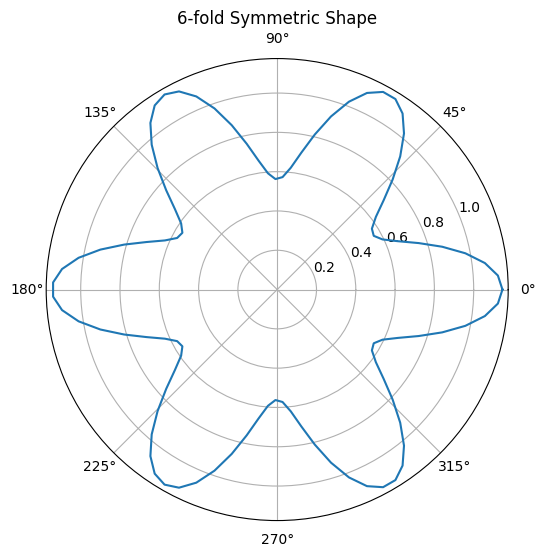

In [2]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(theta, r, d, n, a, L0):
    c = cal_c(r,a,L0)
    return c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
d = 0.8
r = 0.4
n = 6
a = 0.1
L0 = 25
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)
# print(result)
plt.figure(figsize=(6, 6))
plt.polar(theta_values, result)
plt.title(f"{n}-fold Symmetric Shape")
plt.show()
def polar_to_cartesian(result, theta):
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return (x,y)
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)
# print(polar_to_cartesian(result, theta_values))

(101, 3)
[[0.65170185 0.04100161 0.4       ]
 [0.69396948 0.08766873 0.4       ]
 [0.7560519  0.14422461 0.4       ]
 [0.82690949 0.21231427 0.4       ]
 [0.89382078 0.29041998 0.4       ]
 [0.94452056 0.37396215 0.4       ]
 [0.96922197 0.45608124 0.4       ]
 [0.96216915 0.52895697 0.4       ]
 [0.92245676 0.58540886 0.4       ]]


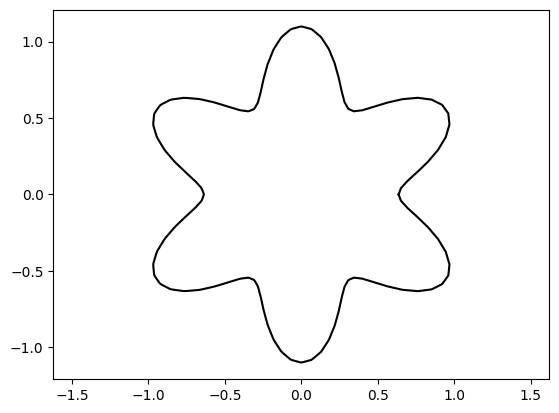

In [28]:
from pyiga.geometry import *
from pyiga import approx, bspline
n_kv = 100
kv = bspline.make_knots(1, 0.0, 1.0, n_kv)
# N = tuple(kv.numdofs for kv in kvs)
r = 2.0
num_res = kv.numdofs
# construct quarter circle using NURBS
theta_values = np.linspace(0, 2 * np.pi, num_res)
result = superformula(theta_values, r, d, n, a, L0)
coeff = np.array(polar_to_cartesian(result, theta_values))
w = np.ones((1,num_res))
coeff = np.vstack((coeff, w)).transpose()
print(coeff.shape)
coeff[:50, 2] = 0.4
print(coeff[1:10])
grid = (np.linspace(0.0, 1.0, 200),)

nurbs = NurbsFunc((kv,), coeff.copy(), weights=None)
vals = nurbs.grid_eval(grid)
vis.plot_geo(nurbs, grid=grid,res=500, linewidth=None, color='black')
axis('equal');


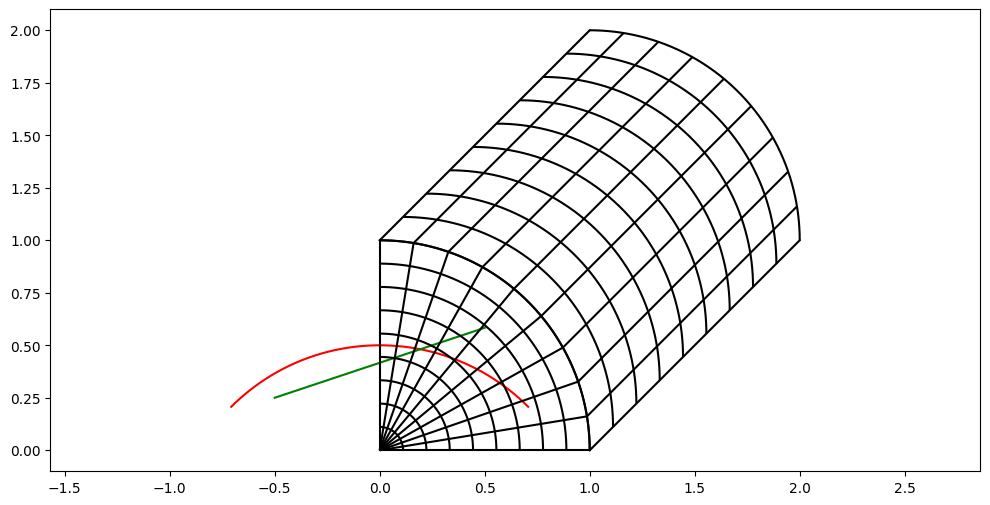

In [ ]:
f = geometry.circular_arc(pi/2)
g = geometry.line_segment([0,0], [1,1])
vis.plot_geo(f.rotate_2d(pi/4).translate([0,-0.5]), color='red')
vis.plot_geo(g.scale([1,1/3]).translate([-.5,.25]), color='green')
axis('equal');
vis.plot_geo(geometry.outer_sum(f, g))
axis('equal');
vis.plot_geo(geometry.outer_product(f, g))
axis('equal');


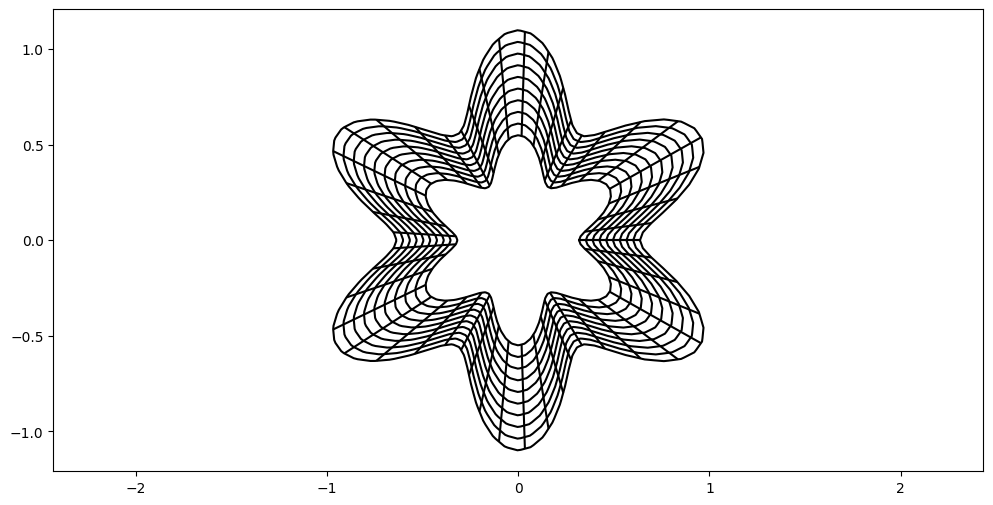

In [ ]:
g = geometry.line_segment([0.5,0.5], [1,1], intervals=100)
geo = geometry.outer_product(nurbs, g)
grid = (np.linspace(0.0, 1.0, 8),)
vis.plot_geo(geo, gridx = 50, gridy = 10, grid = grid, res = 400)
axis('equal');

In [ ]:
geo.coeffs.shape

(101, 11, 3)

In [ ]:
geo.kvs

(KnotVector(array([0.  , 0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
        0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
        0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
        0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
        0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
        0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
        0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
        0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
        0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
        0.98, 0.99, 1.  , 1.  ]), 1),
 KnotVector(array([0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. ]), 1))

In [ ]:
geo.coeffs.shape

(101, 11, 3)

In [ ]:
g = lambda x,y: np.exp(-(x-.8)**2 - (y-.8)**2)  # Dirichlet BC function
f = lambda x,y: 3 * np.sin(10*x) * np.cos(10*y) # source term
kvs = geo.kvs
# compute Dirichlet boundary conditions
bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('right', g), ('top', g)])

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo, res = 10000)
gca().set_aspect('equal')
colorbar();

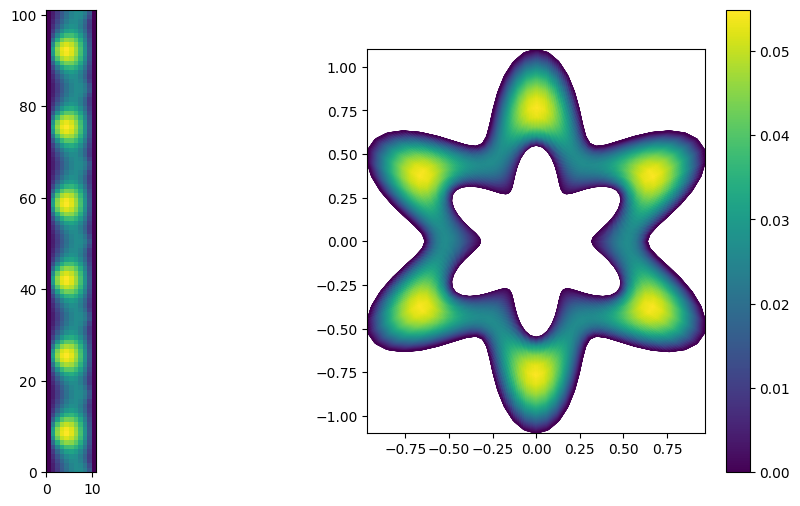

In [ ]:
g = lambda x,y: 0  # Dirichlet BC function
f = lambda x,y: 3 # source term

# compute Dirichlet boundary conditions
bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('left', g), ('right', g)])

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo, res = 500)
gca().set_aspect('equal')
colorbar();

In [ ]:
u.shape

(909,)